># **Fake News Content Detection**





SARA SEÑORÍS PUENTES

+34 653 11 64 51

itasar.ssp@gmail.com

The file is divided in the following sections:

  **1. INTRODUCTION**

  **2. DATA**
  
  **3. PART I**: Using RRNN with tensorflow to solve the problem: LSTMs.

  **4. PART II**: Using transformers to solve the problem: BERT model + classification.

# **1. INTRODUCTION**

Fake news is a news article that is intentionally and verifiably false that are produced online for a variety of purposes, such as financial and political gain with the dishonest intention of manipulating public opinion and/or being entertainment-oriented.

Detecting fake news on social media poses several new and challenging research problems. Its detection is very difficult due to fake news is intentionally written to mislead readers, which makes it nontrivial to detect simply based on news content. The content of fake news is rather diverse in terms of topics, styles and media platforms, and fake news attempts to distort truth with diverse linguistic styles while simultaneously mocking true news.
The extensive spread of fake news has the potential for extremely negative impacts on individuals and society. Therefore, fake news detection on social media has recently become an emerging research that is attracting tremendous attention. Fake news detection on social media presents unique characteristics and challenges which has led to the development of ingenious algorithms to approach them.

In this report we will foccus in solving the problem of fake news with two methods: Long Short-Term Memory (LSTM) and transdormers. LSTM networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems, they have an internal state that can represent context information and keep information about past inputs for an amount of time. The range of contextual information that standard RNNs can access is in practice quite limited. Long Short-Term Memory (LSTM) is an RNN architecture specifically designed to address the problem of contextualisation. In the second part of this report we use Transformers to solver the problem, in particular BERT, which is a pretrained model that has deep bidirectional representations meaning the model learns information from left to right and from right to left. This means that we don’t start from scratch to train the model. Transformers have a attention-mechanism that looks at an input sequence and decides at each step which other parts of the sequence are important. This method is capable of identify keywords that are important to the semantics of the sentence. The literature positions these two methods as the most advanced for text analysis.

The aim of this project is to detect fake news with artificial intelligence methods.


# **2. DATA**

The data cotains fake news and a tag that describe each topic and is labeled as "Barely-True","False","Half-True","Mostly-True" and "True" news.

The data has been cleaned following the next steps:

* Removing nan values, stop words and puntuation.
* Applying stemming: the process of reducing inflection in words to their root.

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
e_train = '/content/drive/My Drive/Train.csv'
e_test = '/content/drive/My Drive/Test.csv'

In [3]:
#install libraries

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
import sqlite3
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text
nltk.download('stopwords')
from wordcloud import WordCloud
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#painting the data 
def paint_data(df):
  df.groupby('Labels').Labels.count().plot(kind = 'bar')
  plt.xlabel('Labels', fontweight='bold', color = 'orange', fontsize='18')
  bars = ('Barely-True','False','Half-True','Mostly-True','Not-Known','True')
  y_pos = np.arange(len(bars))
  plt.xticks(y_pos, bars, color='black', rotation = 45)

  plt.show()

In [5]:
def clean_data(e_train,e_test):
  stemmer = PorterStemmer()
  words = stopwords.words("english")
  #Removing nan values, stop words and puntuation.  
  #Stemming is the process of reducing inflection in words to their root.
  train = pd.read_csv(e_train)
  test = pd.read_csv(e_test)
  train.dropna(inplace=True)
  train.drop_duplicates(inplace=True)
  test.dropna(inplace=True)
  test.drop_duplicates(inplace=True)
  df = pd.concat([train, test]).reset_index(drop=True)
  df['Text_cleaned'] = df['Text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  df['tag_cleaned'] = df['Text_Tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

  # df['Text_and_tag'] = df.Text +' '+ df.Text_Tag
  # df['Text_and_tag_cleaned'] = df['Text_and_tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  train = df[:train.shape[0]]
  test = df[train.shape[0]:]
  return train, test, df

def clean_data_fusion(e_train,e_test):
  stemmer = PorterStemmer()
  words = stopwords.words("english")
  #Removing nan values, stop words and puntuation.  
  #Stemming is the process of reducing inflection in words to their root.
  train = pd.read_csv(e_train)
  test = pd.read_csv(e_test)
  train.dropna(inplace=True)
  train.drop_duplicates(inplace=True)
  test.dropna(inplace=True)
  test.drop_duplicates(inplace=True)
  df = pd.concat([train, test]).reset_index(drop=True)
  df['Text_cleaned'] = df['Text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  df['tag_cleaned'] = df['Text_Tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

  df['Text_and_tag'] = df.Text_cleaned +' '+ df.tag_cleaned
  df['Text_and_tag_cleaned'] = df['Text_and_tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  train = df[:train.shape[0]]
  test = df[train.shape[0]:]
  return train, test, df

In [6]:
train, test, df = clean_data(e_train,e_test)

In [7]:
test.shape

(1267, 5)

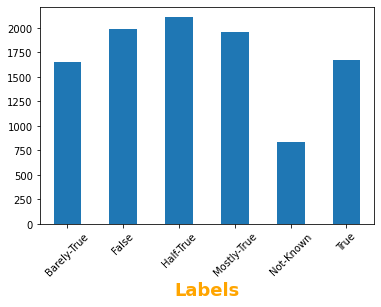

In [8]:
paint_data(df)

## PART I

In [9]:

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [10]:
#clening data
def clean_data_fusion(e_train,e_test):
  stemmer = PorterStemmer()
  words = stopwords.words("english")
  #Removing nan values, stop words and puntuation.  
  #Stemming is the process of reducing inflection in words to their root.
  train = pd.read_csv(e_train)
  test = pd.read_csv(e_test)
  train.dropna(inplace=True)
  train.drop_duplicates(inplace=True)
  test.dropna(inplace=True)
  # test.drop_duplicates(inplace=True)
  df = pd.concat([train, test]).reset_index(drop=True)
  df['Text_cleaned'] = df['Text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  df['tag_cleaned'] = df['Text_Tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

  df['Text_and_tag'] = df.Text_cleaned +' '+ df.tag_cleaned
  df['Text_and_tag_cleaned'] = df['Text_and_tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  train = df[:train.shape[0]]
  test = df[train.shape[0]:]
  return train, test, df

In this section columns Text and tag will be added after being cleaned:

In [11]:
train, test, df = clean_data_fusion(e_train,e_test)

In [12]:
# split the data into test and train 
X = train['Text_and_tag_cleaned']
y = train['Labels']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [13]:
X_val = test['Text_and_tag_cleaned']

In [15]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df['Text_and_tag_cleaned']:
    for j in i:
        list_of_words.append(j)
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

27

In [16]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
# from text to vectors
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [17]:
# Add padding to training and testing
#pad_sequence stacks a list of Tensors along a new dimension, and pads them to equal length
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

In [18]:
tokenizer.fit_on_texts(X_val)
val_sequences = tokenizer.texts_to_sequences(X_val)
padded_val = pad_sequences(val_sequences, maxlen = 29, padding = 'post', truncating = 'post')

In [19]:
padded_test.shape

(1023, 29)

In [20]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 6)
y_test_cat = to_categorical(y_test, 6)

Optimizing parameters of LSTM 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense

def fn_model(lr = 0.1,output_dim=512,lstm_n = 100,first_neuron = 100,second_neuron =100,activation='relu',
             dropout = 0.5,dropout2 = 0.5,optimizer = 'Adam',loss='categorical_crossentropy',last_activation='sigmoid',weight_regulizer=1):
    
    model = Sequential()          
    model.add(Embedding(total_words, output_dim =512))
    model.add(LSTM(lstm_n))                  
    model.add(Dense(first_neuron,
                    input_dim=29,
                    activation='relu'))
    model.add(Dropout(dropout))
    if second_neuron > 0:
      model.add(Dense(second_neuron, activation = activation))
      model.add(Dropout(dropout2))
    model.add(Dense(6,activation = last_activation))
    model.compile(optimizer=optimizer(lr=lr),
                  loss=loss,
                  metrics=['acc'])
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.activations import softmax
from tensorflow.keras.losses import categorical_crossentropy, logcosh

params = {'lr': [0.0001,0.001,0.1, 1],
    #  'output_dim':[512,300],
     'lstm_n':[50,100,150],
     'first_neuron':[50,100,150],
     'second_neuron':[50,100,150],
     'activation':['relu', 'softmax'],
    #  'batch_size': [30,50],
    #  'epochs': [100,200],
     'dropout': [0, 0.5],
     'dropout2': [0,0.5],
     'optimizer': [Adam, Nadam],
     'loss': ['categorical_crossentropy'],
     'last_activation': ['softmax'],
     'weight_regulizer': [None]}


In [23]:
# Use scikit-learn to grid search the weight initialization
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
model_lstm = KerasClassifier(build_fn=fn_model, epochs=100, batch_size=30, verbose=0)

In [ ]:
rsearch = RandomizedSearchCV(estimator=model_lstm, param_distributions=params,n_iter=5, n_jobs=-1, cv=4)

In [ ]:
rsearch_result = rsearch.fit(padded_train, y_train_cat)

In [ ]:
rsearch_result.best_params_

{'activation': 'softmax',
 'dropout': 0,
 'dropout2': 0.5,
 'first_neuron': 150,
 'last_activation': 'softmax',
 'loss': 'categorical_crossentropy',
 'lr': 0.0001,
 'lstm_n': 50,
 'optimizer': tensorflow.python.keras.optimizer_v2.adam.Adam,
 'second_neuron': 150,
 'weight_regulizer': None}

In [ ]:
best_model = rsearch_result.best_estimator_

In [26]:
from keras.models import load_model

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = best_model.predict(padded_test)

In [ ]:
best_model.score(y_pred,y_test)

0.21114370226860046

In [ ]:
y_pred_train = best_model.predict(padded_train)

In [ ]:
rsearch.best_params_

{'activation': 'softmax',
 'dropout': 0,
 'dropout2': 0.5,
 'first_neuron': 150,
 'last_activation': 'softmax',
 'loss': 'categorical_crossentropy',
 'lr': 0.0001,
 'lstm_n': 50,
 'optimizer': tensorflow.python.keras.optimizer_v2.adam.Adam,
 'second_neuron': 150,
 'weight_regulizer': None}

In [ ]:
y_pred_val = best_model.predict(padded_val)
y_pred_val

array([1, 3, 1, ..., 1, 1, 1])

In [ ]:
y_predproba_val = best_model.predict_proba(padded_val)

In [ ]:
df_probabilidades = pd.DataFrame(y_predproba_val)
df_probabilidades.head()

,0,1,2,3,4,5
0,0.147903,0.198423,0.195850,0.196717,0.072559,0.188548
1,0.144086,0.189421,0.201953,0.207721,0.063008,0.193811
2,0.146670,0.199194,0.195103,0.196463,0.072731,0.189838
3,0.153627,0.212291,0.190242,0.174824,0.092727,0.176290
4,0.163401,0.214092,0.191640,0.171998,0.094144,0.164725


In [28]:
load_best_model = load_model('/content/drive/MyDrive/finalized_modelLSTM.h5')

In [34]:
history = load_best_model.fit(padded_train, y_train_cat, batch_size = 30,epochs=100, validation_data=(padded_test, y_test_cat), shuffle=True)

Epoch 1/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7540 - acc: 0.2135 - val_loss: 1.7654 - val_acc: 0.1945
Epoch 2/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7536 - acc: 0.2160 - val_loss: 1.7653 - val_acc: 0.1945
Epoch 3/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7528 - acc: 0.2149 - val_loss: 1.7649 - val_acc: 0.1945
Epoch 4/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7534 - acc: 0.2133 - val_loss: 1.7648 - val_acc: 0.1945
Epoch 5/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7533 - acc: 0.2166 - val_loss: 1.7649 - val_acc: 0.1945
Epoch 6/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7524 - acc: 0.2153 - val_loss: 1.7650 - val_acc: 0.1945
Epoch 7/100
307/307 [==============================] - 2s 7ms/step - loss: 1.7531 - acc: 0.2153 - val_loss: 1.7651 - val_acc: 0.1945
Epoch 8/100
307/307 [==============================] - 2s 7ms/step - 

The model will be trained with neural networks: LSTM

In [35]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
epochs

range(1, 101)

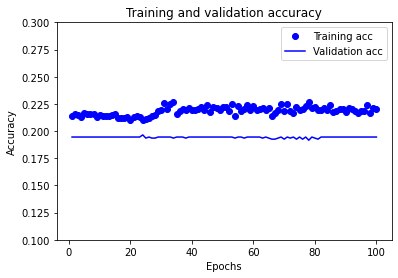

In [40]:

plt.clf()   # clear figure


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.ylim(0.1, 0.3)
# plt.plot(epochs, loss, 'ro', label='Training acc')
# plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

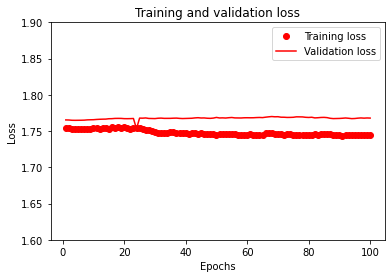

In [43]:
plt.clf()   # clear figure


# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylim(1.6, 1.9)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **PART II**

In [ ]:
# install nltk
# NLTK: Natural Language tool kit
!pip install nltk

In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 1.1MB 12.4MB/s 
     |████████████████████████████████| 890kB 24.5MB/s 
     |████████████████████████████████| 3.0MB 40.8MB/s 
     |████████████████████████████████| 1.1MB 50.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.8-cp36-none-any.whl size=101996 sha256=6f186a03ba6167ec21b3d1d45b4a3613ed84ff410ee5a56bf8dc0f1d1d45a435
  Stored in directory: /root/.cache/pip/wheels/27/ec/b3/d12cc8e4daf77846db6543033d3a5642f204c0320b15945647
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=45e63eb4d680a5851f61ae94c5111c4b7b18f9ee1a80bffee6ab956a9167cd23
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
!pip install catboost

     |████████████████████████████████| 66.2MB 141kB/s 


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier

In [ ]:
train, test, df = clean_data(e_train,e_test)

**From text to vectors: transformation of the data**



* Tag_cleaned will be transformed with CountVectorizer.
* Text_cleaned will be transformed with a pre-trained models:
  1. 'roberta-large-nli-stsb-mean-tokens'
  2.'bert-large-nli-stsb-mean-tokens'
  3.'distilbert-base-nli-stsb-mean-tokens'
  

In [ ]:
def clean_data(e_train,e_test):
  #Removing nan values, stop words and puntuation.  
  #Stemming is the process of reducing inflection in words to their root.
  train = pd.read_csv(e_train)
  test = pd.read_csv(e_test)
  train.dropna(inplace=True)
  train.drop_duplicates(inplace=True)
  test.dropna(inplace=True)
  test.drop_duplicates(inplace=True)
  df = pd.concat([train, test]).reset_index(drop=True)
  df['Text_cleaned'] = df['Text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  df['tag_cleaned'] = df['Text_Tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

  # df['Text_and_tag'] = df.Text +' '+ df.Text_Tag
  # df['Text_and_tag_cleaned'] = df['Text_and_tag'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
  train = df[:train.shape[0]]
  test = df[train.shape[0]:]
  return train, test, df

In [ ]:
def transformations(df, PRETRAINED_MODEL = 'roberta-large-nli-stsb-mean-tokens'):
  #tag column
  Tag_cleaned_values = df.tag_cleaned.values
  cv = CountVectorizer()
  cv_to_Tag_values = cv.fit_transform(Tag_cleaned_values)
  cv_matrix = cv_to_Tag_values.toarray()
  vocab = cv.get_feature_names()
  cv = pd.DataFrame(cv_matrix, columns=vocab)
  #text column
  embedder = SentenceTransformer(PRETRAINED_MODEL)
  word_embeddings = embedder.encode(df.Text_cleaned)
  data = pd.DataFrame(word_embeddings)
  #Concatenation of tag and text dataframes after being transformed
  data12 = pd.concat([data,cv],axis=1)
  data12['Labels'] = df.Labels.values
  #redefining train and test
  train1=data12.iloc[:train.shape[0],]
  test1 = data12.iloc[train.shape[0]:,data12.columns != 'Labels']
  X = train1.drop(['Labels'],axis=1)
  y = train1['Labels']
  #return: spliting train
  return train_test_split(X, y, test_size=0.2, random_state=0)
#X_train, X_test, y_train, y_test = transformations(df)

# *'roberta-large-nli-stsb-mean-tokens'*

In [ ]:

X_train, X_test, y_train, y_test = transformations(df,PRETRAINED_MODEL ='roberta-large-nli-stsb-mean-tokens')

100%|██████████| 1.31G/1.31G [01:07<00:00, 19.6MB/s]


After the transformer BERT it's applied a VotingClassifier with the following classifiers:

* CatBoostClassifier
* LGBMClassifier

In [ ]:
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
def clasifficator(X_train, X_test, y_train, y_test):
  model=CatBoostClassifier(iterations=1000,task_type='GPU')
  lgbm=lgb.LGBMClassifier(n_estimators=100,max_bin=25)
  vclf=VotingClassifier(estimators=[('lgg',lgbm),('xgg',model)],voting='soft')
  vclf.fit(X_train,y_train)
  y_pred = vclf.predict_proba(X_test)
  results=pd.DataFrame(y_pred, columns=[0,1,2,3,4,5])
  prediction_class = vclf.predict(X_test)
  results['predicted_class'] = pd.Series(prediction_class)
  vclf.score(X_test,y_test)
  # classification report(precision, recall, F1-score)
  y_pred_2 = vclf.predict(X_test)
  print(classification_report(y_test, y_pred_2))
  score = log_loss(y_test,vclf.predict_proba(X_test))
  #painting score
  train_sizes = [1, 100, 500, 2000, 5000,6547]
  train_sizes, train_scores, validation_scores = learning_curve(estimator = vclf,X = X_train,y = y_train, train_sizes = train_sizes, cv = 5,scoring = 'accuracy')
  return score,vclf,y_pred_2


In [ ]:
score,model,y_pred= clasifficator(X_train, X_test, y_train, y_test)
score

Learning rate set to 0.099662
0:	learn: 1.7820958	total: 105ms	remaining: 1m 44s
1:	learn: 1.7737405	total: 182ms	remaining: 1m 30s
2:	learn: 1.7662756	total: 256ms	remaining: 1m 25s
3:	learn: 1.7593091	total: 314ms	remaining: 1m 18s
4:	learn: 1.7516388	total: 368ms	remaining: 1m 13s
5:	learn: 1.7447447	total: 422ms	remaining: 1m 9s
6:	learn: 1.7381759	total: 463ms	remaining: 1m 5s
7:	learn: 1.7327951	total: 499ms	remaining: 1m 1s
8:	learn: 1.7285675	total: 540ms	remaining: 59.5s
9:	learn: 1.7241100	total: 586ms	remaining: 58s
10:	learn: 1.7186333	total: 627ms	remaining: 56.4s
11:	learn: 1.7137734	total: 663ms	remaining: 54.6s
12:	learn: 1.7107367	total: 711ms	remaining: 53.9s
13:	learn: 1.7050256	total: 748ms	remaining: 52.7s
14:	learn: 1.7012324	total: 784ms	remaining: 51.5s
15:	learn: 1.6981220	total: 820ms	remaining: 50.4s
16:	learn: 1.6939055	total: 858ms	remaining: 49.6s
17:	learn: 1.6906407	total: 895ms	remaining: 48.8s
18:	learn: 1.6885558	total: 927ms	remaining: 47.9s
19:	lear

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/libs/data/quantization.cpp:2434: All features are either constant or ignored.

  FitFailedWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
4:	learn: 1.7251570	total: 263ms	remaining: 52.3s
5:	learn: 1.7111783	total: 308ms	remaining: 51.1s
6:	learn: 1.6965494	total: 338ms	remaining: 48s
7:	learn: 1.6865894	total: 370ms	remaining: 45.9s
8:	learn: 1.6718636	total: 400ms	remaining: 44s
9:	learn: 1.6615419	total: 423ms	remaining: 41.9s
10:	learn: 1.6487186	total: 451ms	remaining: 40.5s
11:	learn: 1.6362372	total: 479ms	remaining: 39.4s
12:	learn: 1.6218777	total: 505ms	remaining: 38.4s
13:	learn: 1.6105344	total: 535ms	remaining: 37.7s
14:	learn: 1.5954945	total: 562ms	remaining: 36.9s
15:	learn: 1.5810995	total: 585ms	remaining: 35.9s
16:	learn: 1.5654285	total: 609ms	remaining: 35.2s
17:	learn: 1.5534509	total: 632ms	remaining: 34.5s
18:	learn: 1.5435745	total: 659ms	remaining: 34s
19:	learn: 1.5328383	total: 682ms	remaining: 33.4s
20:	learn: 1.5216716	total: 707ms	remaining: 32.9s
21:	learn: 1.5104926	total: 732ms	remaining: 32.6s
22:	learn: 1.5016653	total: 760ms

1.7441944993165466

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.22      0.17      0.19       314
         1.0       0.24      0.35      0.29       387
         2.0       0.24      0.31      0.27       438
         3.0       0.27      0.27      0.27       403
         4.0       0.28      0.03      0.05       187
         5.0       0.22      0.17      0.19       317

    accuracy                           0.24      2046
   macro avg       0.24      0.22      0.21      2046
weighted avg       0.24      0.24      0.23      2046



# *'bert-large-nli-stsb-mean-tokens'*

In [ ]:
X_train, X_test, y_train, y_test = transformations(df,PRETRAINED_MODEL ='bert-large-nli-stsb-mean-tokens')

100%|██████████| 1.24G/1.24G [01:04<00:00, 19.3MB/s]


In [ ]:
score,model,y_pred = clasifficator(X_train, X_test, y_train, y_test)
score

Learning rate set to 0.099662
0:	learn: 1.7823032	total: 83.5ms	remaining: 1m 23s
1:	learn: 1.7729721	total: 154ms	remaining: 1m 17s
2:	learn: 1.7654126	total: 221ms	remaining: 1m 13s
3:	learn: 1.7584550	total: 295ms	remaining: 1m 13s
4:	learn: 1.7513992	total: 340ms	remaining: 1m 7s
5:	learn: 1.7442924	total: 382ms	remaining: 1m 3s
6:	learn: 1.7382009	total: 422ms	remaining: 59.8s
7:	learn: 1.7326442	total: 461ms	remaining: 57.2s
8:	learn: 1.7286341	total: 502ms	remaining: 55.3s
9:	learn: 1.7245322	total: 540ms	remaining: 53.5s
10:	learn: 1.7189409	total: 583ms	remaining: 52.5s
11:	learn: 1.7155815	total: 619ms	remaining: 51s
12:	learn: 1.7120125	total: 654ms	remaining: 49.7s
13:	learn: 1.7075331	total: 691ms	remaining: 48.7s
14:	learn: 1.7030317	total: 733ms	remaining: 48.1s
15:	learn: 1.6994986	total: 775ms	remaining: 47.7s
16:	learn: 1.6949394	total: 814ms	remaining: 47s
17:	learn: 1.6918340	total: 850ms	remaining: 46.4s
18:	learn: 1.6885017	total: 887ms	remaining: 45.8s
19:	learn:

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/libs/data/quantization.cpp:2434: All features are either constant or ignored.

  FitFailedWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
4:	learn: 1.7288000	total: 242ms	remaining: 48.2s
5:	learn: 1.7141093	total: 285ms	remaining: 47.2s
6:	learn: 1.6980209	total: 317ms	remaining: 44.9s
7:	learn: 1.6864011	total: 354ms	remaining: 43.8s
8:	learn: 1.6690982	total: 380ms	remaining: 41.9s
9:	learn: 1.6576569	total: 409ms	remaining: 40.5s
10:	learn: 1.6447729	total: 437ms	remaining: 39.3s
11:	learn: 1.6315799	total: 464ms	remaining: 38.2s
12:	learn: 1.6181009	total: 493ms	remaining: 37.4s
13:	learn: 1.6056783	total: 519ms	remaining: 36.5s
14:	learn: 1.5926849	total: 546ms	remaining: 35.9s
15:	learn: 1.5806641	total: 571ms	remaining: 35.1s
16:	learn: 1.5659033	total: 595ms	remaining: 34.4s
17:	learn: 1.5527647	total: 622ms	remaining: 33.9s
18:	learn: 1.5418805	total: 651ms	remaining: 33.6s
19:	learn: 1.5297455	total: 676ms	remaining: 33.1s
20:	learn: 1.5174741	total: 707ms	remaining: 33s
21:	learn: 1.5060562	total: 734ms	remaining: 32.6s
22:	learn: 1.4951489	total: 7

1.758293819661041

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.23      0.15      0.18       314
         1.0       0.25      0.36      0.30       387
         2.0       0.24      0.30      0.26       438
         3.0       0.27      0.31      0.29       403
         4.0       0.24      0.03      0.06       187
         5.0       0.24      0.20      0.22       317

    accuracy                           0.25      2046
   macro avg       0.25      0.22      0.22      2046
weighted avg       0.25      0.25      0.24      2046



# *'distilbert-base-nli-stsb-mean-tokens'*

In [ ]:
X_train, X_test, y_train, y_test = transformations(df,PRETRAINED_MODEL ='distilbert-base-nli-stsb-mean-tokens')

100%|██████████| 245M/245M [00:16<00:00, 14.7MB/s]


In [ ]:
score,model,y_pred = clasifficator(X_train, X_test, y_train, y_test)
score

Learning rate set to 0.099662
0:	learn: 1.7808121	total: 65ms	remaining: 1m 4s
1:	learn: 1.7720870	total: 126ms	remaining: 1m 2s
2:	learn: 1.7645934	total: 182ms	remaining: 1m
3:	learn: 1.7574550	total: 221ms	remaining: 55s
4:	learn: 1.7507049	total: 260ms	remaining: 51.7s
5:	learn: 1.7457938	total: 299ms	remaining: 49.5s
6:	learn: 1.7389605	total: 338ms	remaining: 47.9s
7:	learn: 1.7334691	total: 376ms	remaining: 46.6s
8:	learn: 1.7276640	total: 405ms	remaining: 44.6s
9:	learn: 1.7232809	total: 434ms	remaining: 43s
10:	learn: 1.7184679	total: 463ms	remaining: 41.6s
11:	learn: 1.7142513	total: 492ms	remaining: 40.5s
12:	learn: 1.7102106	total: 527ms	remaining: 40s
13:	learn: 1.7058280	total: 556ms	remaining: 39.2s
14:	learn: 1.7020956	total: 585ms	remaining: 38.4s
15:	learn: 1.6979751	total: 621ms	remaining: 38.2s
16:	learn: 1.6944578	total: 650ms	remaining: 37.6s
17:	learn: 1.6904267	total: 679ms	remaining: 37.1s
18:	learn: 1.6874905	total: 707ms	remaining: 36.5s
19:	learn: 1.6841249	

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/libs/data/quantization.cpp:2434: All features are either constant or ignored.

  FitFailedWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
4:	learn: 1.7280017	total: 132ms	remaining: 26.2s
5:	learn: 1.7157144	total: 157ms	remaining: 26s
6:	learn: 1.7001164	total: 187ms	remaining: 26.5s
7:	learn: 1.6865489	total: 213ms	remaining: 26.4s
8:	learn: 1.6743735	total: 243ms	remaining: 26.7s
9:	learn: 1.6620984	total: 278ms	remaining: 27.5s
10:	learn: 1.6481354	total: 299ms	remaining: 26.9s
11:	learn: 1.6332549	total: 321ms	remaining: 26.4s
12:	learn: 1.6193405	total: 343ms	remaining: 26.1s
13:	learn: 1.6063898	total: 365ms	remaining: 25.7s
14:	learn: 1.5939413	total: 399ms	remaining: 26.2s
15:	learn: 1.5821696	total: 421ms	remaining: 25.9s
16:	learn: 1.5675136	total: 450ms	remaining: 26s
17:	learn: 1.5552168	total: 474ms	remaining: 25.9s
18:	learn: 1.5420026	total: 511ms	remaining: 26.4s
19:	learn: 1.5284253	total: 534ms	remaining: 26.2s
20:	learn: 1.5171155	total: 554ms	remaining: 25.8s
21:	learn: 1.5047084	total: 574ms	remaining: 25.5s
22:	learn: 1.4900841	total: 594

1.753586517522208

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.19      0.15      0.17       314
         1.0       0.24      0.33      0.28       387
         2.0       0.22      0.29      0.25       438
         3.0       0.25      0.27      0.26       403
         4.0       0.25      0.03      0.06       187
         5.0       0.22      0.16      0.18       317

    accuracy                           0.23      2046
   macro avg       0.23      0.21      0.20      2046
weighted avg       0.23      0.23      0.22      2046



# **Conclusion**

In PART I the problem has been solve with LSTM, a recurrent neural network with long term memory (Long short-term memory) designed to improve text contextualization. In this section the text of the articles has been joined with the information on the label to introduce everything in the same sequence. The data has been tokenised and its dimensions are matched since embedding layer requires that the input data be integer encoded. The LSTM layer has been previously optimized with KerasClassifier.

The maximun accuracy is 25%, with log loss fuction = 1.75 obtained in PART II by using transformers, in particular,'bert-large-nli-stsb-mean-tokens', followed by a VotingClassifier composed of two classificators: CatBoostClassifier and LGBMClassifier.

The data has been cleaned by removing stop words, puntuation and by applying stemming.